In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import datetime

from matplotlib.figure import Figure

from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
from datetime import datetime
%load_ext google.cloud.bigquery
from google.cloud import bigquery

from datetime import datetime
from collections import namedtuple

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [2]:
df= pd.read_csv("1008.csv",  skiprows = 4)

In [3]:
df.columns = ["name", "callno", 'voyage', 'region',"dwt", "port", "berth", 'operation', 'commodity','category', 'quantity','units', 'ata', 'atb', 'atc','atd']

# Preprocessing the data

In [4]:
#Taking only those columns
df = df[["name", "callno", "dwt", "port", "berth", 'operation', 'commodity','category', 'quantity', 'ata', 'atb', 'atc','atd']]

In [5]:
df['name'] = df['name'].apply(lambda x: str(x).lower())
df['port'] = df['port'].apply(lambda x: str(x).lower())
df['berth'] = df['berth'].apply(lambda x: str(x).lower())
#df['voyage'] = df['voyage'].apply(lambda x: str(x).lower())
df['commodity'] = df['commodity'].apply(lambda x: str(x).lower())
df['category'] = df['category'].apply(lambda x: str(x).lower())
df['operation'] = df['operation'].apply(lambda x: str(x).lower())

df['operation'] = df['operation'].replace('loading', 'L')
df['operation'] = df['operation'].replace('discharging', 'D')

In [6]:
# To datatime
df['ata'] =  pd.to_datetime(df['ata'])
df['atb'] =  pd.to_datetime(df['atb'])
df['atc'] =  pd.to_datetime(df['atc'])
df['atd'] =  pd.to_datetime(df['atd'])

In [7]:
#Taking only records with positive quantities
df = df[(df['quantity'] > 0)]

In [8]:
#Taking the vessels  that have occurence of more than 3 times
df = df[df.groupby('name')['name'].transform('count').ge(3)]


# New variables, port_time(ata - atd)

In [9]:
df['port_time'] =(df['atd'] - df['ata']).astype('timedelta64[m]') 
df['port_time'] = df['port_time'].apply(lambda x :round(x/60,2))



## Creating a pivot table /grouping by individual ship and ata) and aggregating commodity, category ad quantity for one ship Moreover counting how many unique category, commodity counts are on the ship

In [11]:
gr = df.groupby(['name', 'ata']).agg(
    t_commodity = pd.NamedAgg(column = 'commodity', aggfunc = lambda x: ','.join(x)),
    t_quantity = pd.NamedAgg(column = 'quantity',aggfunc = sum),
    t_category = pd.NamedAgg(column = 'category', aggfunc = lambda x: ','.join(x.unique())),
    oper = pd.NamedAgg(column = 'operation', aggfunc = lambda x: ','.join(x.unique())),
    avg_port_time = pd.NamedAgg(column = 'port_time', aggfunc = np.mean      ),
    call_count = pd.NamedAgg(column = 'callno', aggfunc = lambda x: len(x.unique())) ,
    counts = pd.NamedAgg(column = 'operation', aggfunc =  lambda x: len(x))
)

### From below we can observe trip of each ship and aggregated items on th ship. Counts stand for the amount of operation done by that ship, for example count =2 means , it had to load diesel ad cooking oil

## Next is to merge the aggregated data with previous data that had each row correspond to operation. So after this merge and drop of dublicates we can obtain the dataframe as what was shown above.


In [13]:
fin = df.merge(gr, on = ['name','ata'], how='inner')


In [14]:
fin.drop_duplicates(['name', 'ata'],keep ='first', inplace=True)

In [15]:
fin = fin.reset_index(drop = True)

In [18]:
# Next we get rid of dublicates in common lists of commodity

In [19]:
fin['t_commodity'] = fin['t_commodity'].apply(lambda x: x.split(','))
fin['t_commodity'] = fin['t_commodity'].apply(lambda x: set(x))
fin['t_commodity'] = fin['t_commodity'].apply(lambda x: list(x))
fin['t_commodity'] = fin['t_commodity'].apply(lambda x: sorted(x))

In [20]:
fin = fin[['name',"dwt", "port", "berth", 'oper',"call_count", 't_commodity','t_category', 't_quantity','counts','avg_port_time', 'ata', 'atb', 'atc','atd']]

# Analyze of porvoo port

In [21]:
po = fin[fin['port'] == 'porvoo'].reset_index(drop = True)

In [22]:
po= po[po.groupby('name')['name'].transform('count').ge(3)].reset_index(drop = True)
#drop vessel which occuried less that 3 times

In [23]:
# new time variable, length of operation. ATB-ATC
po['ope'] =(po['atc'] - po['atb']).astype('timedelta64[m]') 
po['ope'] = po['ope'].apply(lambda x :round(x/60,2))

# Length of operation where Risti was interested, ATB-ATD
po['rist_ope'] =(po['atd'] - po['atb']).astype('timedelta64[m]') 
po['rist_ope'] = po['rist_ope'].apply(lambda x :round(x/60,2))

# Time from ATC-ATD
po['delta_dep'] =(po['atd'] - po['atc']).astype('timedelta64[m]') 
po['delta_dep'] = po['delta_dep'].apply(lambda x :round(x/60,2))

In [24]:
# Aggregating by vessel and operation,  with sum of quantity

In [25]:
gr_po = po.groupby(['name', 'ata','ope', 'rist_ope','avg_port_time','delta_dep']).agg(
   
  
   
    agg_cat = pd.NamedAgg(column = 't_category', aggfunc = lambda x: x.sum()),
    agg_operation = pd.NamedAgg(column = 'oper', aggfunc = lambda x: x.sum()),
    
    sum_quantity = pd.NamedAgg(column = 't_quantity', aggfunc = np.sum),
    sum_counts = pd.NamedAgg(column = 'counts', aggfunc = np.sum)
   
)

In [27]:
join = po.merge(gr_po, on = ['name','ata'], how='inner')
join.drop_duplicates(['name', 'ata'],keep ='first', inplace=True)

In [28]:
join['agg_operation'].value_counts()

L               1897
D                878
D,L               37
L,D               36
others             5
L,others           4
D,technician       3
nan                2
others,L           2
L,nan              2
nan,L              1
Name: agg_operation, dtype: int64

In [29]:
# Sme ships had Loading and Discharging at the same trip.

In [30]:
l_d = join[(join['agg_operation'] == 'D,L') | (join['agg_operation'] == 'L,D')]

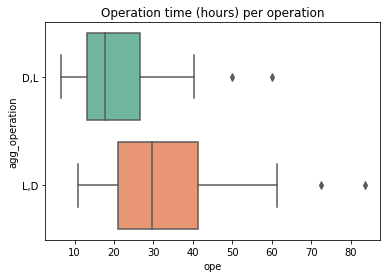

In [31]:

ax = sns.boxplot(x= l_d['ope'], y =l_d["agg_operation"], palette="Set2").set_title('Operation time (hours) per operation')

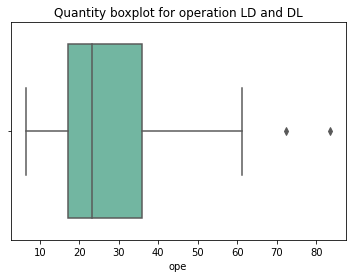

In [32]:
ax = sns.boxplot(x= l_d['ope'], palette="Set2").set_title('Quantity boxplot for operation LD and DL')

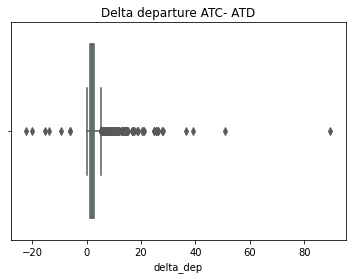

In [33]:
ax = sns.boxplot(x= join['delta_dep'], palette="Set2").set_title('Delta departure ATC- ATD')

# Machine learning phase
## Preparation of data for RF

In [35]:
rf_po = join[['ata','dwt', 'berth', 't_category', 't_quantity', 'counts', 'ope', 'rist_ope', 'avg_port_time', 'oper']]

Loading data

In [36]:
rf_po_l = rf_po[rf_po['oper'] == 'D'].reset_index(drop = True)

In [37]:
#rf_po_l['t_category'] = rf_po_l['t_category'].apply(lambda x : x.replace(' ', '', x.count(' ')))

In [38]:
# separating categories
rf_po_l['t_category'] = rf_po_l['t_category'].apply(lambda x : x.replace(',', ', ', x.count(',')).replace(',', ' ,', x.count(',')))

In [40]:
#rf_po_l['t_category'] = rf_po_l['t_category'].apply(lambda x: x.replace('diesel fuel', '1').replace('naphtha', '17'))

In [41]:
#rf_po_l['t_category'] = rf_po_l['t_category'].apply(lambda x: x.replace('motor gasoline', '2').replace('fueloil', '3').replace('fuel oil','4'))

In [42]:
#rf_po_l['t_category'] = rf_po_l['t_category'].apply(lambda x: x.replace('marine fuel', '5').replace('renewable diesel', '6').replace('base oil','7'))

In [43]:
#rf_po_l['t_category'] = rf_po_l['t_category'].apply(lambda x: x.replace('gasoline component', '8').replace('heavy feedstock', '9').replace('gasoil','10'))

In [44]:
#rf_po_l['t_category'] = rf_po_l['t_category'].apply(lambda x: x.replace('heavy 4', '11').replace('other', '12').replace('crude oil','13'))

In [45]:
#rf_po_l['t_category'] = rf_po_l['t_category'].apply(lambda x: x.replace('jet fuel', '14').replace('heavy feedstock', '15').replace('middle distillate feedstock','16'))

In [46]:
# import labelencoder
#from sklearn.preprocessing import LabelEncoder
# instantiate labelencoder object
#le = LabelEncoder()

In [47]:
#rfe = rf_po_l

In [48]:
#rf_po_l['t_category'] = rf_po_l['t_category'].apply(lambda x : x.replace(',', '', x.count(',')))

In [49]:
#rf_po_l['t_category'] = rf_po_l['t_category'].astype('category')   

In [50]:
#rf_po_l['t_category'] = rf_po_l['t_category'].cat.codes

In [51]:
#Taking only occurrences where counts are > 5
en_po_l= rf_po_l[rf_po_l.groupby('t_category')['t_category'].transform('count').ge(5)].reset_index(drop = True)


In [52]:
#Susan Li XGboost imports
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

from scipy import stats
from scipy.stats import norm, skew
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV, ElasticNet
from xgboost import XGBRegressor, plot_importance 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold


from sklearn.model_selection import cross_val_score, cross_validate, TimeSeriesSplit, RandomizedSearchCV, GridSearchCV, cross_val_predict

## Feature engineering

In [53]:
# Time variables
en_po_l['month'] = en_po_l['ata'].apply(lambda x: x.month)
en_po_l['day'] = en_po_l['ata'].apply(lambda x: x.day)
en_po_l['weekday'] = en_po_l['ata'].apply(lambda x: x.dayofweek)

In [54]:
en_po_l['t_categor'] = en_po_l['t_category'].apply(lambda x: x.split(','))
en_po_l['t_categor'] = en_po_l['t_categor'].apply(lambda x: set(x))

en_po_l['t_categor'] = en_po_l['t_categor'].apply(lambda x: list(x))
en_po_l['t_categor'] = en_po_l['t_categor'].apply(lambda x: sorted(x))
en_po_l['count_cat'] = en_po_l['t_categor'].apply(lambda x: len(x))


In [61]:
# drop some columns
en_po_l = en_po_l.drop(columns = ['ata', 'oper', 't_categor','avg_port_time'])

In [62]:
#en_po_l['ope'] = en_po_l['rist_ope'] # for operation time we now take ATB-ATD

In [65]:
#en_po_l = en_po_l.drop(columns = ['rist_ope'])

## Sketch to check how skewed it the target variable


 mu = 19.24 and sigma = 8.00



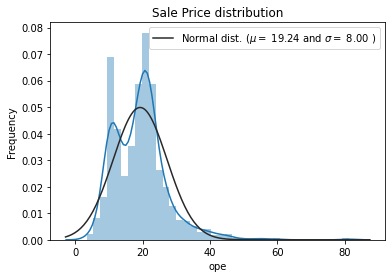

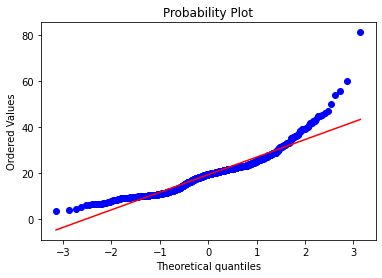

In [66]:
sns.distplot(en_po_l['ope'] , fit=norm);
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(en_po_l['ope'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Sale Price distribution')
#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(en_po_l['ope'], plot=plt)
plt.show();

### Correlation between numerical variables

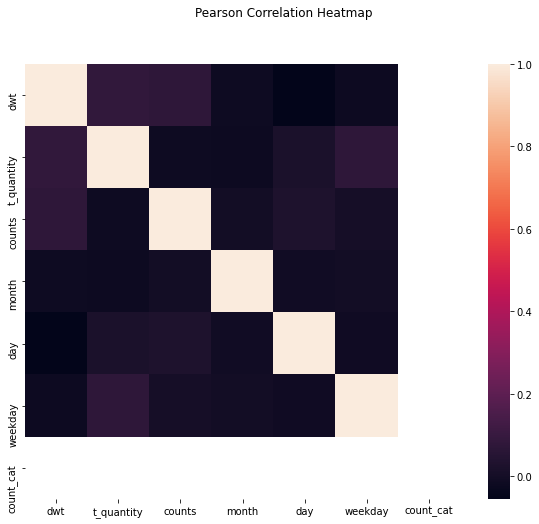

In [67]:
pd.set_option('precision',2)
plt.figure(figsize=(10, 8))
sns.heatmap(en_po_l.drop(['ope'],axis=1).corr(), square=True)
plt.suptitle("Pearson Correlation Heatmap")
plt.show();

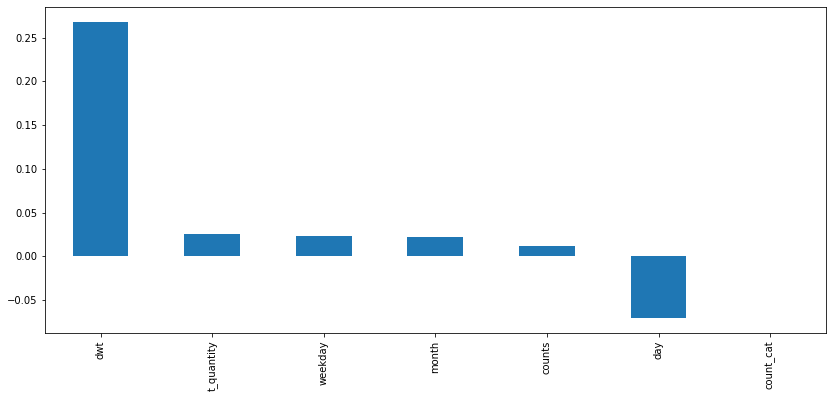

In [69]:
corr_with_sale_price = en_po_l.corr()["ope"].sort_values(ascending=False)
plt.figure(figsize=(14,6))
corr_with_sale_price.drop("ope").plot.bar()
plt.show();

# Weight of the ship (or maybe the ship itself) correlates with the operation time. 

In [134]:
en = en_po_l

In [70]:
#Dummy variables for categorical:jetties and t_categories
en_po_l = pd.get_dummies(en_po_l)

In [71]:

en_po_l = en_po_l.fillna(df.mean())

X, y = en_po_l.drop(['ope'], axis = 1), en_po_l['ope']
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [72]:
en_po_l.columns

Index(['dwt', 't_quantity', 'counts', 'ope', 'month', 'day', 'weekday',
       'count_cat', 'berth_jetty 1', 'berth_jetty no. 1', 'berth_jetty no. 2',
       'berth_jetty no. 3', 'berth_jetty no. 4', 'berth_jetty no. 5',
       'berth_neste oil', 't_category_condensate', 't_category_crude oil',
       't_category_diesel fuel', 't_category_gasoil',
       't_category_gasoline component', 't_category_heavy feedstock',
       't_category_heavy fuel oil', 't_category_heavy gas oil',
       't_category_jet fuel', 't_category_middle distillate feedstock',
       't_category_motor gasoline', 't_category_naphtha',
       't_category_renewable diesel'],
      dtype='object')

# Xgboost

In [74]:
#Basic model
xgb_model1 = XGBRegressor()
xgb_model1.fit(X_train, y_train, verbose=False)
y_train_pred1 = xgb_model1.predict(X_train)
y_pred1 = xgb_model1.predict(X_test)

train_mse1 = mean_squared_error(y_train_pred1, y_train)
test_mse1 = mean_squared_error(y_pred1, y_test)
train_rmse1 = np.sqrt(train_mse1)
test_rmse1 = np.sqrt(test_mse1)
print('Train RMSE: %.2f' % train_rmse1)
print('Test RMSE: %.2f' % test_rmse1)

test_errors = y_pred1 - y_test
train_errors = y_train_pred1 - y_train

train_mae = np.abs(train_errors).mean()
train_mape = train_mae/np.mean(y)

test_mae = np.abs(test_errors).mean()
test_mape = test_mae/np.mean(y)

print('Train MAE: %.2f' % train_mae)
print('Test MAE: %.2f' % test_mae)
print('Train MAPE: %.2f' % train_mape)
print('Test MAPE: %.2f' % test_mape)
print('Mean Absolute Error:', round(np.mean(test_errors), 2), 'hours.')



Train RMSE: 0.43
Test RMSE: 6.51
Train MAE: 0.29
Test MAE: 3.93
Train MAPE: 0.02
Test MAPE: 0.20
Mean Absolute Error: -0.45 hours.


In [75]:
scores_xgb = cross_validate(xgb_model1,X_train, y_train,cv=10, 
                         scoring=['neg_mean_squared_error', 'neg_mean_absolute_error',
                                  'neg_mean_squared_log_error'],
                         return_train_score=True, n_jobs=-1)
# root mean squared error
print('XGBoost: Average RMSE train data: %.2f'
      % (sum([np.sqrt(-1 * x) for x in scores_xgb['train_neg_mean_squared_error']])/len(scores_xgb['train_neg_mean_squared_error'])))
print('XGBoost: Average RMSE test data:  %.2f' 
     % ( sum([np.sqrt(-1 * x) for x in scores_xgb['test_neg_mean_squared_error']])/len(scores_xgb['test_neg_mean_squared_error'])))

# mean absolute error
print('XGBoost: Average MAE train data: %.2f' 
      % (sum([(-1 * x) for x in scores_xgb['train_neg_mean_absolute_error']])/len(scores_xgb['train_neg_mean_absolute_error'])))
print('XGBoost: Average MAE test data: %.2f' 
      % (sum([(-1 * x) for x in scores_xgb['test_neg_mean_absolute_error']])/len(scores_xgb['test_neg_mean_absolute_error'])))

# root mean squared log error
print('XGBoost: Average RMSLE train data: %.2f'
      % (sum([np.sqrt(-1 * x) for x in scores_xgb['train_neg_mean_squared_log_error']])/len(scores_xgb['train_neg_mean_squared_log_error'])))
print('XGBoost: Average RMSLE test data: %.2f' 
      % (sum([np.sqrt(-1 * x) for x in scores_xgb['test_neg_mean_squared_log_error']])/len(scores_xgb['test_neg_mean_squared_log_error'])))

XGBoost: Average RMSE train data: 0.33
XGBoost: Average RMSE test data:  6.21
XGBoost: Average MAE train data: 0.22
XGBoost: Average MAE test data: 3.94
XGBoost: Average RMSLE train data: 0.02
XGBoost: Average RMSLE test data: 0.29


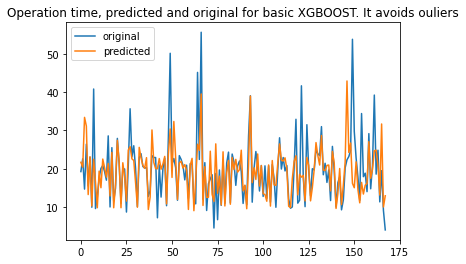

In [76]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred1, label="predicted")
plt.title("Operation time, predicted and original for basic XGBOOST. It avoids ouliers")
plt.legend()
plt.show()


In [77]:
#Grid Search on parameters
xgb1 = XGBRegressor()
parameters = {
             
              'learning_rate': [.03, .07, .01,0.3], #so called `eta` value
              'max_depth': [5,6, 7],
              'min_child_weight': [4,300],
              'silent': [1],
              'subsample': [0.7,0.8],
              'colsample_bytree': [0.7,0.8],
              'n_estimators': [500, 800,1000]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train,
         y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)



Fitting 2 folds for each of 288 candidates, totalling 576 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    5.3s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   24.1s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:   54.5s
[Parallel(n_jobs=5)]: Done 576 out of 576 | elapsed:  1.2min finished


[12:11:53] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.48251288703641565
{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'silent': 1, 'subsample': 0.8}


## The grid search gives colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'silent': 1, 'subsample': 0.8

In [86]:
xgb_m= XGBRegressor(
    #colsample_bytree = 0.7, n_estimators=500, learning_rate=0.01,min_child_weight = 4, max_depth=5, subsample =0.8)
                    n_estimators=1000, subsample= 0.7,learning_rate=0.01,reg_alpha = 0.7, max_depth=7, gamma=0.5)
xgb_m.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)
y_train_pred2 = xgb_m.predict(X_train)
y_pred2 = xgb_m.predict(X_test)

train_mse2 = mean_squared_error(y_train_pred2, y_train)
test_mse2 = mean_squared_error(y_pred2, y_test)

train_mse2 = mean_squared_error(y_train_pred2, y_train)
test_mse2 = mean_squared_error(y_pred2, y_test)
train_rmse2 = np.sqrt(train_mse2)
test_rmse2 = np.sqrt(test_mse2)
print('Train RMSE: %.2f' % train_rmse2)
print('Test RMSE: %.2f' % test_rmse2)

test_errors = y_pred2 - y_test
train_errors = y_train_pred2 - y_train

train_mae = np.abs(train_errors).mean()
train_mape = train_mae/np.mean(y)

test_mae = np.abs(test_errors).mean()
test_mape = test_mae/np.mean(y)

print('Train MAE: %.2f' % train_mae)
print('Test MAE: %.2f' % test_mae)
print('Train MAPE: %.2f' % train_mape)
print('Test MAPE: %.2f' % test_mape)
print('Mean Absolute Error:', round(np.mean(test_errors), 2), 'hours.')



Train RMSE: 2.83
Test RMSE: 6.40
Train MAE: 1.76
Test MAE: 3.68
Train MAPE: 0.09
Test MAPE: 0.19
Mean Absolute Error: -1.14 hours.


In [81]:
scores_xgb = cross_validate(xgb_m,X_train, y_train,cv=10, 
                         scoring=['neg_mean_squared_error', 'neg_mean_absolute_error',
                                  'neg_mean_squared_log_error'],
                         return_train_score=True, n_jobs=-1)
# root mean squared error
print('XGBoost: Average RMSE train data: %.2f'
      % (sum([np.sqrt(-1 * x) for x in scores_xgb['train_neg_mean_squared_error']])/len(scores_xgb['train_neg_mean_squared_error'])))
print('XGBoost: Average RMSE test data:  %.2f' 
     % ( sum([np.sqrt(-1 * x) for x in scores_xgb['test_neg_mean_squared_error']])/len(scores_xgb['test_neg_mean_squared_error'])))

# mean absolute error
print('XGBoost: Average MAE train data: %.2f' 
      % (sum([(-1 * x) for x in scores_xgb['train_neg_mean_absolute_error']])/len(scores_xgb['train_neg_mean_absolute_error'])))
print('XGBoost: Average MAE test data: %.2f' 
      % (sum([(-1 * x) for x in scores_xgb['test_neg_mean_absolute_error']])/len(scores_xgb['test_neg_mean_absolute_error'])))



XGBoost: Average RMSE train data: 1.18
XGBoost: Average RMSE test data:  5.74
XGBoost: Average MAE train data: 0.83
XGBoost: Average MAE test data: 3.58


# Better results that first model on the test data. 

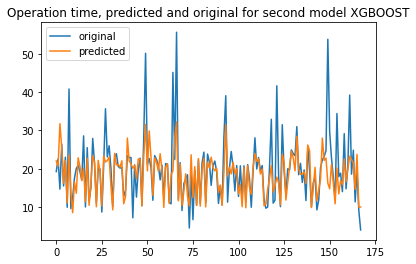

In [82]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred2, label="predicted")
plt.title('Operation time, predicted and original for second model XGBOOST')
plt.legend()
plt.show()


In [87]:
from collections import OrderedDict
OrderedDict(sorted(xgb_m.get_booster().get_fscore().items(), key=lambda t: t[1], reverse=True))

OrderedDict([('t_quantity', 3962),
             ('dwt', 2543),
             ('day', 2533),
             ('month', 1821),
             ('weekday', 1346),
             ('t_category_motor gasoline', 389),
             ('counts', 276),
             ('berth_jetty no. 1', 274),
             ('t_category_heavy feedstock', 255),
             ('t_category_renewable diesel', 227),
             ('t_category_gasoil', 211),
             ('t_category_jet fuel', 211),
             ('t_category_gasoline component', 199),
             ('berth_jetty no. 2', 192),
             ('t_category_condensate', 172),
             ('t_category_naphtha', 171),
             ('berth_jetty no. 4', 157),
             ('berth_jetty no. 5', 127),
             ('berth_jetty no. 3', 115),
             ('t_category_diesel fuel', 113),
             ('t_category_middle distillate feedstock', 113),
             ('t_category_heavy gas oil', 98),
             ('berth_neste oil', 86),
             ('t_category_heavy fuel oil', 22

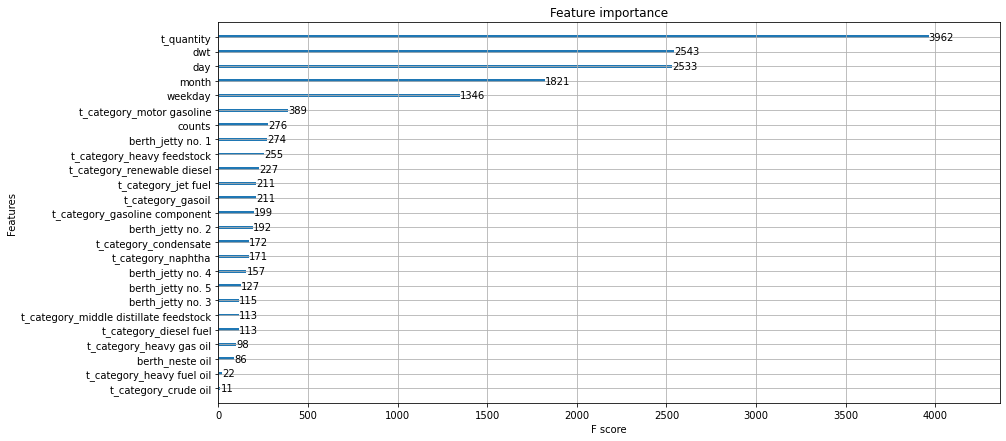

In [85]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (14, 7)
plot_importance(xgb_m)
pyplot.show()

For the Discharging, t_quantity has the biggest feature importance score
Generally, importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.

This importance is calculated explicitly for each attribute in the dataset, allowing attributes to be ranked and compared to each other.

Importance is calculated for a single decision tree by the amount that each attribute split point improves the performance measure, weighted by the number of observations the node is responsible for. The performance measure may be the purity (Gini index) used to select the split points or another more specific error function.

The feature importances are then averaged across all of the the decision trees within the model.
Xgboost provides good results, however it prone to overfitting, that is why the hyperparameter tuning is essential.
Data has some seasonality, which should be investigated. As day and month shows high importance
